# Baichuan2-7B QLoRA微调实战

信息抽取数据集采自CCF2022工业知识图谱关系抽取比赛，并针对一个工业制造领域的相关故障文本，抽取4种类型的实体（部件单元、性能表征、故障状态和检测工具）以及4种类型的关系（部件故障、性能故障、检测工具、组成）。由于数据量较少，在实战过程中，随机抽取50条数据作为测试数据，其余数据作为训练数据集。

## 0 Baichuan2-7B-Chat 预训练模型

经实测，在线量化8bits会占用大量的内存并且速度缓慢，因此采用离线量化，将8bits量化模型保存下来。

In [1]:
from argparse import Namespace
cfg = Namespace()

# model
cfg.model_name_or_path = "/mnt/d/models/Baichuan2-7B-Chat-8bits"
cfg.train_path = "/home/huang/codespace/learn2LLM/dataset/fine-tuning/spo_0.json"
cfg.test_path = "/home/huang/codespace/learn2LLM/dataset/fine-tuning/spo_1.json"
cfg.num_return_sequences = 1
cfg.max_len = 1024
cfg.max_src_len = 640
cfg.batch_size = 2
cfg.prompt_text = "你现在是一个信息抽取模型，请你帮我抽取出关系内容为\"性能故障\", \"部件故障\", \"组成\"和 \"检测工具\"的相关三元组，三元组内部用\"_\"连接，三元组之间用\\n分割。文本："


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.generation.utils import GenerationConfig

modelpath = "/mnt/d/models/Baichuan2-7B-Chat"
quant8_saved_dir = "/mnt/d/models/Baichuan2-7B-Chat-8bits"

# 保存 8bits量化模型
# model = AutoModelForCausalLM.from_pretrained(modelpath, load_in_8bit=True, device_map="cpu", trust_remote_code=True)
# model.save_pretrained(quant8_saved_dir)

模型保存后，也要将其余的文件复制到quant8_saved_dir文件中，这里省略了

In [3]:
tokenizer = AutoTokenizer.from_pretrained(quant8_saved_dir, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(quant8_saved_dir, device_map="auto", trust_remote_code=True)
model.generation_config = GenerationConfig.from_pretrained(quant8_saved_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
messages = []
messages.append({"role": "user", "content": "解释一下“温故而知新”"})
response = model.chat(tokenizer, messages)
print("Baichuan2: ", response)

Baichuan2:  "温故而知新"是一个成语，源自于中国古代哲学家和教育家孔子。这个成语的意思是通过回顾和了解过去的事情，从而发现新的知识和道理。它强调了学习和成长的过程应该是一个不断循环和进步的过程，既要学习新知识，也要回顾和巩固旧知识。

这个成语可以用来指导我们在日常生活中如何更好地学习和成长。例如，当我们学习一门新课程或者掌握一项新技能时，可以回顾以前学过的相关知识，以便更好地理解和应用新技术。同时，通过不断地学习和实践，我们可以发现新的知识和道理，从而不断提高自己的能力和素质。


### 微调前的效果：

In [5]:
prompt_text = "你现在是一个信息抽取模型，请你帮我抽取出关系内容为\"性能故障\", \"部件故障\", \"组成\"和 \"检测工具\"的相关三元组，三元组内部用\"_\"连接，三元组之间用\\n分割。文本："

def get_prompt(text):
    return prompt_text + text

In [6]:
messages = []
messages.append({"role": "user", "content": get_prompt("故障现象：奔腾B70做PDI检查时车辆无法启动。")})
response = model.chat(tokenizer, messages)
print("Baichuan2: ", response)

Baichuan2:  性能故障_部件故障_组成, 检测工具_奔腾B70做PDI检查


## 1 加载训练数据

In [4]:
from torch.utils.data import DataLoader, RandomSampler
from data_set import Seq2SeqDataSet2, coll_fn

train_dataset = val_dataset = Seq2SeqDataSet2(cfg.train_path, tokenizer, cfg.max_len, cfg.max_src_len,
                               cfg.prompt_text)

train_dataloader = DataLoader(train_dataset,
                              batch_size=cfg.batch_size,
                              sampler=RandomSampler(train_dataset),
                              collate_fn=coll_fn,
                              drop_last=True,
                              num_workers=2)

val_dataloader = DataLoader(val_dataset,
                            batch_size=cfg.batch_size,
                            shuffle=False,
                            collate_fn=coll_fn,
                            num_workers=2)

## 2 加载模型

In [4]:
from peft import get_peft_model, LoraConfig, TaskType

model.supports_gradient_checkpointing = True  #节约cuda，但可能会使得训练时间变长
model.gradient_checkpointing_enable() # 作用同上
model.enable_input_require_grads() # 作用同上

model.config.use_cache = False  # 关闭了模型的缓存机制，该设置可以避免一些警告，但在模型推理时需要重新开启

In [5]:
from peft import prepare_model_for_kbit_training 
model = prepare_model_for_kbit_training(model) #预处理量化模型以适配LoRA

In [12]:
import bitsandbytes as bnb 
def find_all_linear_names(model):
    """
    找出所有全连接层，为所有全连接添加低秩adapter
    """
    cls = bnb.nn.Linear8bitLt
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

lora_modules = find_all_linear_names(model)

print(lora_modules)

['o_proj', 'up_proj', 'W_pack', 'gate_proj', 'down_proj']


In [13]:
from peft import AdaLoraConfig
peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=64,
    lora_alpha=16, lora_dropout=0.05,
    target_modules= lora_modules
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()

trainable params: 26,838,912 || all params: 7,532,812,320 || trainable%: 0.35629338499170254


## 3 模型微调

In [14]:
import torch
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net(**batch).loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存lora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 

In [15]:
# 此处设置is_paged=True，即使用Paged Optimizer，减少训练过程中Cuda OOM的风险。
optimizer = bnb.optim.adamw.AdamW(peft_model.parameters(),
                                  lr=6e-05,is_paged=True)  


keras_model = KerasModel(peft_model,loss_fn = None,
        optimizer=optimizer) 

ckpt_path = 'baichuan2_qlora'

<<<<<< ⚡️ cuda is used >>>>>>


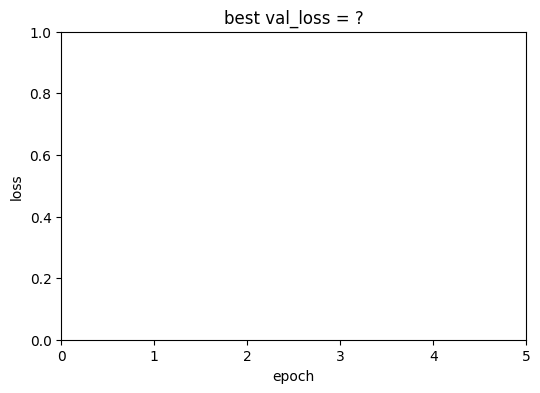

/home/huang/anaconda3/envs/chatglm2/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


OutOfMemoryError: CUDA out of memory. Tried to allocate 86.00 MiB (GPU 0; 12.00 GiB total capacity; 10.88 GiB already allocated; 0 bytes free; 11.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [16]:
keras_model.fit(train_data = train_dataloader,
                val_data = val_dataloader,
                epochs=5, patience=5,
                monitor='val_loss', mode='min',
                ckpt_path = ckpt_path,
               )